In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
dataframe = pd.read_csv("./TreinamentoHackathon/GlobalTemperatures.csv")

<h2>Informações sobre o Dataset</h2><br>
O dataset contem dados sobre o <b>aquecimento global</b>, com inicio em <b>1850</b> ate <b>2015</b>, com dados gerados todo dia primeiro de cada mês, ou seja, <b>12</b> amostras por ano.

<b>LandAverageTemperature</b>: temperatura média global da terra em graus Celsius<br>
<b>LandAverageTemperatureIncerteza</b>: o intervalo de confiança de 95% em torno da média<br>
<b>LandMaxTemperature</b>: temperatura máxima média global da terra em graus Celsius<br>
<b>Incerteza LandMaxTemperature</b>: o intervalo de confiança de 95% em torno da temperatura máxima da terra<br>
<b>LandMinTemperature</b>: temperatura mínima média global da terra em graus Celsius<br>
<b>Incerteza LandMinTemperature</b>: o intervalo de confiança de 95% em torno da temperatura mínima do solo<br>
<b>LandAndOceanAverageTemperature</b>: temperatura média global da terra e do oceano em graus Celsius<br>
<b>Incerteza LandAndOceanAverageTemperature</b>: o intervalo de confiança de 95% em torno da temperatura média global da terra e do oceano

<h2>Objetivo</h2>

Será avaliado o <b>entendimento do dataset</b> e a <b>montagem do modelo</b>. Deverá ser veito uma regressão utilizando <b>LSTM</b> com <b>Tensorflow</b> versão (1.13.2), quem optar por utilizar <b>Keras</b> terá uma nota reduzida para <b>40%</b> do valor total. A escolha de qual classe a ser predita e quais features serão utilizadas para realizar a predição é de escolha de cada participante.<br>
<p><b>Obs.</b>: A forma de vizualização e explicação sobre o que foi predito será avaliado tambem.</p>

In [3]:
dataframe.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
2,1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
3,1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
4,1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [4]:
dataframe.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')

In [5]:
def get_year_and_month(Dataframe):
    date_list = dataframe["dt"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")).to_list()
    date_list = [x.date().timetuple()[:2] for x in date_list]
    
    year_list, day_list = zip(*date_list)
    
    Dataframe["Year"] = year_list
    Dataframe["Month"] = day_list
    Dataframe = Dataframe.drop(["dt"], axis=1)
    
    return Dataframe

In [6]:
dataframe = get_year_and_month(dataframe)

In [7]:
dataframe.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,Year,Month
0,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367,1850,1
1,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414,1850,2
2,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341,1850,3
3,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267,1850,4
4,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249,1850,5


In [8]:
dataframe_treinamento = dataframe.loc[dataframe["Year"] < 2000]

In [9]:
dataframe_teste = dataframe.loc[dataframe["Year"] >= 2000]

<h2> Dataset </h2><br>
O dataset foi separado em dois dataframes, <b>dataframe_treinamento</b> e <b>dataframe_teste</b>, o dataframe de treinamento possui dados dos anos de <b>1850</b> a <b>1999</b>, o de teste vai de <b>2000</b> a <b>2015</b>. O dataframe de treinamento deverá ser divido entre treino e validação, com <b>70% para treino e 30% para validação</b>, e o dataframe de teste será feito para comparar os dados preditos com base na classe que foi escolhida.

In [10]:
dataframe_treinamento.loc[:, "Year"].unique()

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [11]:
dataframe_teste.loc[:, "Year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

<h2>Visualização dos dados</h2>

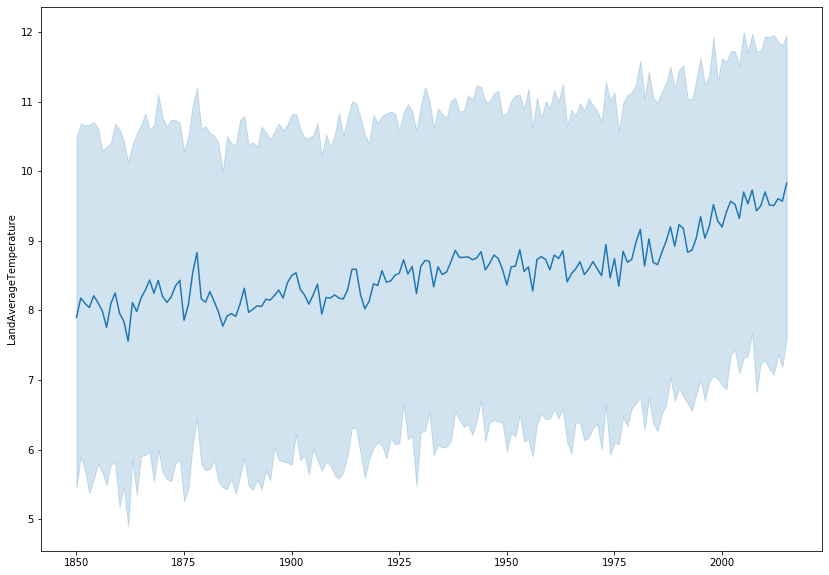

In [12]:
plt.figure(figsize=(14,10))
sns.lineplot(dataframe["Year"].values, dataframe["LandAverageTemperature"]);

<h2>Modelo</h2><br>

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [14]:
data_features = dataframe_treinamento.drop(["LandAverageTemperature"], axis=1).values
data_class = dataframe_treinamento["LandAverageTemperature"].values

In [15]:
# X_test e y_test
data_feature_predict = dataframe_teste.drop(["LandAverageTemperature"], axis=1).values
data_class_predict = dataframe_teste["LandAverageTemperature"].values

In [16]:
X_train, X_val, y_train, y_val = train_test_split(data_features, data_class)

In [17]:
y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)

data_class_predict = np.expand_dims(data_class_predict, -1)

In [18]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1350, 9) (1350, 1) (450, 9) (450, 1)


In [19]:
def LSTM_model(num_input, num_output, num_hidden_dense=32, num_hidden_LSTM=32, dropout=0.2):

    tf.reset_default_graph()

    w1 = tf.Variable(initial_value=tf.truncated_normal([num_hidden_LSTM, num_hidden_dense], stddev=0.2), name='w1')
    w2 = tf.Variable(initial_value=tf.truncated_normal([num_hidden_dense, num_output], stddev=0.2), name='w2')
    b1 = tf.Variable(tf.zeros([num_hidden_dense]), name='b1')
    b2 = tf.Variable(tf.zeros([num_output]), name='b2')

    with tf.name_scope('input'):
        X = tf.placeholder(tf.float32, [None, num_input])
        Y = tf.placeholder(tf.float32, [None, num_output])

    with tf.name_scope('LSTM_1'):  
        x = tf.split(X, num_input, 1)
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden_LSTM, name='LSTM_1')
        outputs_1, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    with tf.name_scope('LSTM_2'):    
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden_LSTM, name='LSTM_2')
        outputs_2, states = tf.contrib.rnn.static_rnn(lstm_cell, outputs_1, dtype=tf.float32)
        
    with tf.name_scope('LSTM_3'):    
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden_LSTM, name='LSTM_3')
        outputs_3, states = tf.contrib.rnn.static_rnn(lstm_cell, outputs_2, dtype=tf.float32)

    with tf.name_scope('Dense_1'):
        dense_1 = tf.add(tf.matmul(outputs_3[-1], w1), b1, name="Dense_1")

    with tf.name_scope('Dropout'):
        dropout = tf.nn.dropout(dense_1, rate=dropout, name="Dropout_1")

    with tf.name_scope('Dense_out'):
        output = tf.add(tf.matmul(dropout, w2), b2, name="Dense_out")

    return output, X, Y

In [20]:
tf.reset_default_graph()
num_input = len(X_train[0])
num_classe = 1

# Numero de celulas de memoria LSTM definido pelo numero de entradas.
num_hidden_LSTM = num_input
num_hidden_Dense = 128
learning_rate = 0.008
epochs = 250
step = 25
batch_size = 50

output, X, Y = LSTM_model(num_input, num_classe, num_hidden_Dense, num_hidden_LSTM)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [21]:
with tf.name_scope('Loss'): 
    # Função de loss RMSE.
    loss_op = tf.reduce_mean(tf.sqrt(tf.losses.mean_squared_error(predictions=output, labels=Y)), name="Loss")
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

saver = tf.train.Saver(max_to_keep=5, keep_checkpoint_every_n_hours=1)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    # saver = tf.train.Saver(max_to_keep=1, keep_checkpoint_every_n_hours=1)
    sess.run(init)
    losses_train = []
    losses_eval = []
    
    num_batchs = X_train.shape[0] // batch_size
    for epoch in range(epochs + 1):
        
        for batch in range(1, num_batchs + 1):
            
            # batch das amostras, o batch está sendo feito de forma simples, e por isso,
            # o valor de batch precisa ser divisor de 1350 que é o valor de amostras.
            # caso o valor de amostras varie, então será necessário uma função mais complexa.
            X_train_batch = X_train[batch_size * (batch - 1): batch_size * (batch)]
            y_train_batch = y_train[batch_size * (batch - 1): batch_size * (batch)]            
            
            dict_train = {X: X_train_batch, Y: y_train_batch}
            dict_eval = {X: X_val, Y: y_val}
            
            _, train_loss = sess.run([train_op, loss_op], feed_dict=dict_train)
            eval_loss = sess.run(loss_op, feed_dict=dict_eval)

            losses_train.append(train_loss)
            losses_eval.append(eval_loss)

        if epoch % step == 0:
            print("Epoch {}..... Train_Loss: {:.4f}\tEval_loss: {:.4f}".format(epoch, train_loss, eval_loss))
            # saver.save(sess, "./new_weight/model_save/model_LSTM.ckpt", global_step=step)
            
    predict = sess.run(output, feed_dict={X:data_feature_predict})

Instructions for updating:
Use tf.cast instead.
Epoch 0..... Train_Loss: 4.4169	Eval_loss: 3.7943
Epoch 25..... Train_Loss: 0.5620	Eval_loss: 0.5153
Epoch 50..... Train_Loss: 0.5445	Eval_loss: 0.5298
Epoch 75..... Train_Loss: 0.6460	Eval_loss: 0.5068
Epoch 100..... Train_Loss: 0.4619	Eval_loss: 0.5748
Epoch 125..... Train_Loss: 0.4942	Eval_loss: 0.4661
Epoch 150..... Train_Loss: 0.5047	Eval_loss: 0.4437
Epoch 175..... Train_Loss: 0.5053	Eval_loss: 0.3896
Epoch 200..... Train_Loss: 0.4547	Eval_loss: 0.4001
Epoch 225..... Train_Loss: 0.5384	Eval_loss: 0.3976
Epoch 250..... Train_Loss: 0.3714	Eval_loss: 0.3879


<h2>Métricas</h2>

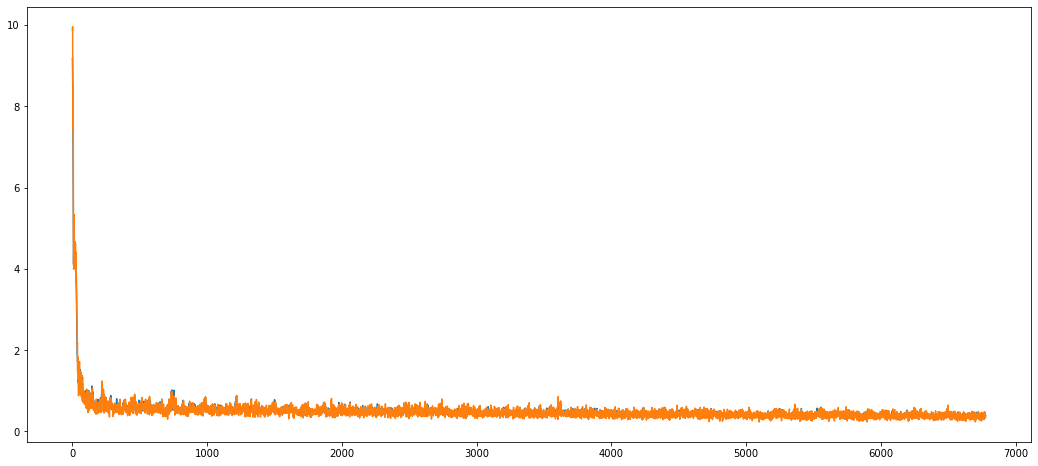

In [22]:
plt.figure(figsize=(18,8))

sns.lineplot([x for x in range(len(losses_eval))], losses_eval)
sns.lineplot([x for x in range(len(losses_train))], losses_train)

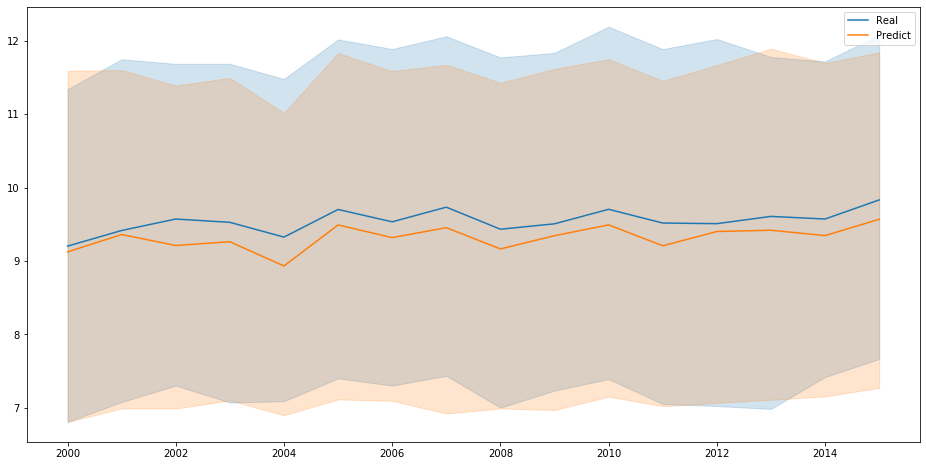

In [23]:
plt.figure(figsize=(16,8))
sns.lineplot([int(x) for x in data_feature_predict[:, -2]], data_class_predict.reshape(data_class_predict.shape[0]), label="Real")
sns.lineplot([int(x) for x in data_feature_predict[:, -2]], predict.reshape(predict.shape[0]), label="Predict");

In [24]:
predict[:10]

array([[ 3.070015],
       [ 4.224692],
       [ 6.02964 ],
       [ 9.037937],
       [11.635208],
       [14.134495],
       [15.031866],
       [14.953955],
       [12.24695 ],
       [ 9.269458]], dtype=float32)

In [25]:
data_class_predict[:10]

array([[ 2.95 ],
       [ 4.184],
       [ 6.219],
       [ 9.552],
       [11.874],
       [14.06 ],
       [14.848],
       [14.519],
       [12.547],
       [ 9.486]])

<h2>Conclusão</h2>

In [26]:
from sklearn.metrics import r2_score

In [27]:
r2_score(data_class_predict, predict)

0.9903283208015817

O valor de confiança da regressão é de 99%, sendo feito três camadas LSTM com 9 celulas em cada e uma camada FullyConnected de 128 celulas, learning rate de 0.008, 250 epocas e batch de 50 amostras. O modelo conseguiu atingir uma ótima aproximação valor, para cada batch e por epoca o valor variou conforme o esperado para uma rede LSTM.